In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [22]:
train_path = './traindata/'
transform_rgb = transforms.Compose(
        [transforms.RandomRotation(10),
         transforms.Resize((224,224)),
         transforms.ToTensor(),
         transforms.Normalize((0.485,0.456,0.406), (0.229,0.224,0.225)),
         #prevent overfiting
         transforms.RandomHorizontalFlip()
         ])
trainset = torchvision.datasets.ImageFolder(train_path, transform=transform_rgb)
train_set, test_set = train_test_split(trainset, train_size=0.8,random_state=309)
#batch_size=32 Speed up trainning
trainloader = torch.utils.data.DataLoader(train_set, batch_size=10, shuffle=True)
testloader = torch.utils.data.DataLoader(test_set, batch_size=10)

### cnn structure by using pre_train Model feature

In [26]:
class VGGNet16(nn.Module):
    def __init__(self):
        super(VGGNet16, self).__init__()
        #using vgg16 feature(including convolution layer and pooling layer)
        self.features = torchvision.models.vgg16_bn(pretrained=True).features
        self.classifier = nn.Sequential(
            nn.Linear(512*7*7, 256, bias=False),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),

            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),

            nn.Linear(128, 3, bias=False)
        )
        # Initialize Weights
        for m in self.modules():
            if isinstance(m, nn.Linear):
                # method 2 kaiming
                nn.init.kaiming_normal_(m.weight.data)

    def forward(self, x):
        x = self.features(x)  # The forward propagation
        x = x.view(-1, 512*7*7)#output of convolutional layer into a one-dimensional vector
        x = self.classifier(x)  # Then splice the results of features (feature layer of network output) to the classifier
        return x
'''training net'''
model = VGGNet16().to(device)  # Define the network model for training
lossF = nn.CrossEntropyLoss() # make output more smoother(incorporated softmax())
optimizer = torch.optim.SGD(model.parameters(), lr=0.001,momentum=0.9)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [27]:
# import torch
# import torch.nn as nn

# # 确定计算设备（GPU或CPU）
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # 导入数据加载器和模型定义（VGGNet16）

# # 初始化损失记录列表
# train_loss_all, train_accur_all, test_loss_all, test_accur_all = [], [], [], []

# print("Strat Trainning")

# # 定义训练和测试的共用函数
# def run_epoch(data_loader, is_training):
#     num = 0 # 记录样本数
#     accuracy = 0 # 记录准确数
#     loss_sum = 0 # 记录损失总和

#     with torch.set_grad_enabled(is_training):
#         for data in data_loader:
#             images, labels = data
#             images, labels = images.to(device), labels.to(device)

#             optimizer.zero_grad() if is_training else None

#             # 前向传播
#             outputs = model(images)
#             loss = lossF(outputs, labels)

#             # 反向传播和梯度更新（仅训练阶段执行）
#             if is_training:
#                 loss.backward()
#                 optimizer.step()

#             # 计算损失总和
#             loss_sum += loss.item() * images.size(0)

#             # 计算准确数
#             outputs = torch.argmax(outputs, 1)
#             accuracy += torch.sum(outputs == labels)
#             num += images.size(0)

#     # 计算本轮损失和准确度
#     loss_all = loss_sum / num
#     accuracy_all = accuracy.double().item() / num

#     return loss_all, accuracy_all

# for epoch in range(10): # 循环10个训练轮次
#     train_loss, train_accuracy = run_epoch(trainloader, is_training=True)
#     test_loss, test_accuracy = run_epoch(testloader, is_training=False)

#     # 记录损失和准确度
#     train_loss_all.append(train_loss)
#     train_accur_all.append(train_accuracy)
#     test_loss_all.append(test_loss)
#     test_accur_all.append(test_accuracy)

#     # Print the results for the current epoch
#     print(f"Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

# print('Training finished')

# to record the loss data
train_loss_all,train_accur_all,test_loss_all,test_accur_all = [],[],[],[]# this is for record the loss and accuarcy
print("start training")
##optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
for epoch in range(10):  # loop over the dataset multiple times
    train_num = 0.0
    train_accuracy = 0.0
    train_loss = 0.0
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(inputs)
        loss = lossF(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        train_loss += abs(loss.item()) * inputs.size(0)
        outputs = torch.argmax(outputs, 1)
        accuracy = torch.sum(outputs == labels)
        train_accuracy = train_accuracy + accuracy
        train_num += inputs.size(0)
    print("epoch：{} ， train-Loss：{} , train-accuracy：{}".format(epoch + 1, train_loss / train_num,
                                                                train_accuracy / train_num))
    train_accur_all.append(train_accuracy.double().item() / train_num)
    train_loss_all.append(train_loss / train_num)
    # since we're not training, we don't need to calculate the gradients for our outputs
    test_loss = 0
    test_accuracy = 0.0
    test_num = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data# calculate outputs by running images through the network
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = lossF(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)# the class with the highest energy is what we choose as prediction
            test_loss = test_loss + abs(loss.item())*images.size(0)
            outputs = torch.argmax(outputs, 1)
            accuracy = torch.sum(outputs == labels)
            test_accuracy = test_accuracy + accuracy
            test_num += images.size(0)
        test_loss_all.append(test_loss/test_num)
        test_accur_all.append(test_accuracy.double().item()/test_num)
        print("test-accuracy"+str(test_accuracy.double().item()/test_num))
print('Finished Training')

start training
epoch：1 ， train-Loss：0.5320094437157762 , train-accuracy：0.7750487923622131
test-accuracy0.8928571428571429
epoch：2 ， train-Loss：0.2177807077866317 , train-accuracy：0.9263187050819397
test-accuracy0.9129464285714286
epoch：3 ， train-Loss：0.18098054969999883 , train-accuracy：0.9405525922775269
test-accuracy0.9241071428571429
epoch：4 ， train-Loss：0.15047682488144226 , train-accuracy：0.9506000280380249
test-accuracy0.9174107142857143
epoch：5 ， train-Loss：0.0944351564109039 , train-accuracy：0.9734858870506287
test-accuracy0.9274553571428571
epoch：6 ， train-Loss：0.056081415173603516 , train-accuracy：0.9829751253128052
test-accuracy0.9196428571428571
epoch：7 ， train-Loss：0.06342029747868057 , train-accuracy：0.9810214638710022
test-accuracy0.9263392857142857
epoch：8 ， train-Loss：0.06474748999658343 , train-accuracy：0.9807423949241638
test-accuracy0.9095982142857143
epoch：9 ， train-Loss：0.040672668279680475 , train-accuracy：0.9874406456947327
test-accuracy0.9486607142857143
epoch

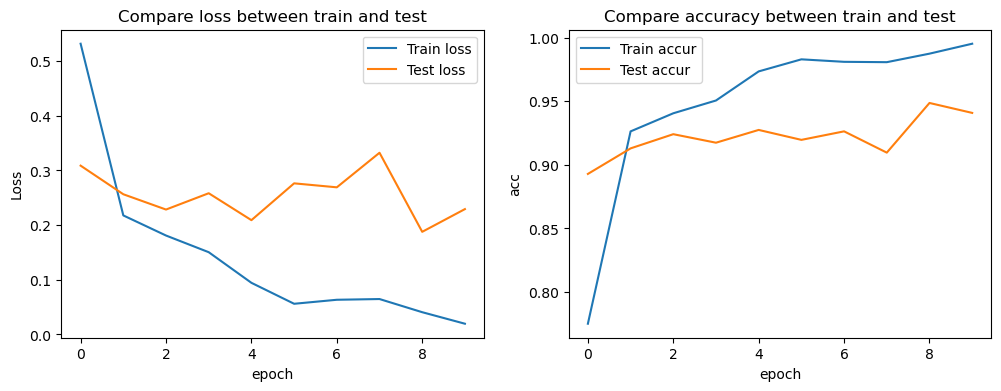

In [31]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.subplot(1 , 2 , 1)
plt.title("Compare loss between train and test")
plt.plot(range(len(train_loss_all)) , train_loss_all,label = "Train loss")
plt.plot(range(len(test_loss_all)), test_loss_all,label = "Test loss")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.subplot(1, 2, 2)
plt.title("Compare accuracy between train and test")
plt.plot(range(len(train_accur_all)) , train_accur_all,label = "Train accur")
plt.plot(range(len(test_accur_all)) , test_accur_all,label = "Test accur")
plt.xlabel("epoch")
plt.ylabel("acc")
plt.legend()
plt.show()

In [33]:
PATH = './model_final.pth'
torch.save(model.state_dict(), PATH)